### Façade features tagging

In this notebook i am going to tag some other façade features, such as: 

<ol>
<li><b>Car counts and areas</b> in sidewalk views</li>
<li><b>Number of windows</b></li>
<li><b>Window-to-wall ratio</b>, which could be related to the eyes-on-the street phenomenon. I just learned that this has a name, i just think about it as how much you can see from the inside of the façade (potentially since windows might be closed).</li>
<ol>

Let's use the same views i applied for the <code>first street_view_features</code> notebook.

In [1]:
from alivestreets.sampling.street_sampler import StreetSampler

#As always define the street sampler
n_points = 200
street_sampler = StreetSampler(max_points = n_points)

#Open the geojson and distribute the same points we have been working with. Ideally there will be methods
#for saving the sampling_points but i need to work on that. I need to figure out the details. 

street_sampler.open_streets("data/network_2.geojson")
street_sampler.sample_streets_no_intersections()

print(f"The number of sampling points is {len(street_sampler.get_all_sampling_points())}")

The number of sampling points is 279


In [2]:
#Open the sampling point images data, which we downloaded in first_street_view_features.ipynb
import os
import json

path_points_dictionary = os.path.join(os.getcwd(),"data","network_images_demo", "point_dictionaries.jsonl")
points_data = []

with open(path_points_dictionary, "r") as f:
    for line in f:
        points_data.append(json.loads(line))



from alivestreets.features.facade_features import FacadeFeatureExtractor
from tqdm import tqdm
import cv2
import numpy as np


n_points = len(points_data)


#It's important to know and apply this dictionary. 
#I will also make it the default value in the future. 
class_dictionary = {
                "bench":0,
                "door":1,
                "facade":2,
                "graffiti":3,
                "person":4,
                "sidewalk":5,
                "signage":6,
                "sky":7,
                "street_light":8,
                "trash":9,
                "utility_pole":10,
                "vegetation":11,
                "vehicle":12,
                "window":13
            }

path_model = os.path.join(os.getcwd(), "model_facades.pt")

#Define the Facade feature extractor 
facade_feat_extractor = FacadeFeatureExtractor(
    #Code dyslexia
    model_path = path_model,
    facade_feature_id_dictionary = class_dictionary,
    threshold = 0.2
)


### Car counts

In [3]:

car_counts = []

feature_to_examine = "vehicle"
car_count_list = []
confidences_car_counts = []

for i in tqdm(range(0,len(points_data))):
    point_dictionary = points_data[i]
    view_paths = point_dictionary["view_paths"]

    car_counts = 0
    n_paths = len(view_paths)
    mean_confidence = 0
    for j in range(0,len(view_paths)):
        img = cv2.imread(view_paths[j])
        #By default the feature that is obtained is the number of instances in the image. I will show how to extract
        #other attributes like area of elements in the next cell. 

        results = facade_feat_extractor.compute([feature_to_examine], img, confidence_threshold = 0.2)
        count, confidences = results[feature_to_examine]
        car_counts += count
        if(len(confidences) > 0):
            mean_confidence += np.mean(confidences)
    if(n_paths>0):
        mean_confidence = mean_confidence/n_paths

    car_count_list.append(car_counts)
    confidences_car_counts.append(mean_confidence)
    



100%|██████████| 279/279 [05:12<00:00,  1.12s/it]


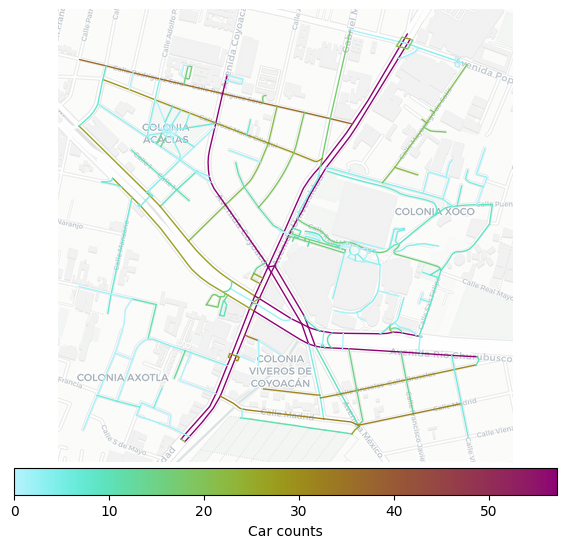

In [4]:
from alivestreets.visualization.map_visualizer import MapVisualizer
import cmcrameri.cm as cm
#Great, now you tag the GVI just like every other feature.
street_sampler.tag_streets(
    "Car counts", 
    car_count_list,
    method = "sum"
)

#I recently added an option to use a cmap so let's use a color blind friendly one
cmap = cm.hawaii_r

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(street_sampler, 
"Car counts", 
variable_type="continuous",
edge_width = 1,
cmap = cmap)
vis.draw_networks(colorbar_label = "Car counts", colorbar_orientation = "horizontal", min_percentile=1, max_percentile=99)
vis.add_basemap(alpha = 0.7)
vis.finalize_map()

### Street lights

In [5]:
street_lights = []

feature_to_examine = "street_light"
street_light_count_list = []
confidences_street_light_counts = []

for i in tqdm(range(0,len(points_data))):
    point_dictionary = points_data[i]
    view_paths = point_dictionary["view_paths"]

    street_lights= 0
    n_paths = len(view_paths)
    mean_confidence = 0
    for j in range(0,len(view_paths)):
        img = cv2.imread(view_paths[j])
        #By default the feature that is obtained is the number of instances in the image. I will show how to extract
        #other attributes like area of elements in the next cell. 

        results = facade_feat_extractor.compute([feature_to_examine], img, confidence_threshold = 0.2)
        count, confidences = results[feature_to_examine]
        street_lights += count
        if(len(confidences) > 0):
            mean_confidence += np.mean(confidences)
    if(n_paths>0):
        mean_confidence = mean_confidence/n_paths

    street_light_count_list.append(street_lights)
    confidences_street_light_counts.append(mean_confidence)
    

100%|██████████| 279/279 [05:32<00:00,  1.19s/it]


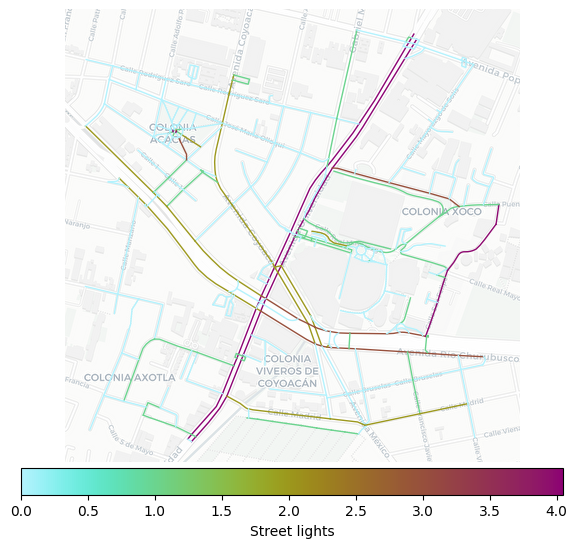

In [6]:
from alivestreets.visualization.map_visualizer import MapVisualizer
import cmcrameri.cm as cm
#Great, now you tag the GVI just like every other feature.
street_sampler.tag_streets(
    "street_lights", 
    street_light_count_list,
    method = "sum"
)

#I recently added an option to use a cmap so let's use a color blind friendly one
cmap = cm.hawaii_r

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(street_sampler, 
"street_lights", 
variable_type="continuous",
edge_width = 1,
cmap = cmap)
vis.draw_networks(
    colorbar_label = "Street lights", 
    colorbar_orientation = "horizontal", 
    min_percentile=1, 
    max_percentile=99)
vis.add_basemap(alpha = 0.7)
vis.finalize_map()

### Car area fractions on images

This would be the average area fraction occupied by cars in the collected images. 

In [7]:
feature_to_examine = "vehicle"
car_area_list = []
confidences_car_areas = []

#Since we don't want count we need to create some function that will calculate exactly what we want
#I really want to use lambda for this so let's do that. 

area_fraction_calculation = lambda facade_calculator, image, classes, threshold: {
    facade_class: (
        np.logical_or.reduce(
            facade_calculator.get_masks(image, threshold, facade_class)[0]
        ).sum() / (np.size(image, 0) * np.size(image, 1)),
        facade_calculator.get_masks(image, threshold, facade_class)[1]
    )
    for facade_class in classes
}

for i in tqdm(range(0,len(points_data))):
    point_dictionary = points_data[i]
    view_paths = point_dictionary["view_paths"]

    car_area = 0
    n_paths = len(view_paths)
    mean_confidence = 0
    for j in range(0,len(view_paths)):
        img = cv2.imread(view_paths[j])
        #By default the feature that is obtained is the number of instances in the image. I will show how to extract
        #other attributes like area of elements in the next cell. 

        results = facade_feat_extractor.compute([feature_to_examine], img, operation = area_fraction_calculation, confidence_threshold = 0.2)
        area, confidences = results[feature_to_examine]
        car_area += area/len(view_paths)
        if(len(confidences) > 0):
            mean_confidence += np.mean(confidences)
    if(n_paths>0):
        mean_confidence = mean_confidence/n_paths
        

    car_area_list.append(car_area)
    confidences_car_areas.append(mean_confidence)


    

100%|██████████| 279/279 [10:48<00:00,  2.32s/it]


In [8]:
street_sampler.tag_streets(
    "Car area", 
    car_area_list,
    method = "mean"
)

In [9]:
#Actually i want to display the areas occupied by cars but weighted by the length of the
#street, otherwise the results might be weird

street_means = []
street_lengths = []

for street in street_sampler.streets:
    value = street.get_attribute_value("Car area")
    length = street.get_complete_length()

    if value is not None and length > 0:
        street_means.append(value)
        street_lengths.append(length)
    else:
        street_means.append(None)
        street_lengths.append(0.0)

total_length = sum(length for length in street_lengths if length > 0)

weighted_means = [
    value * (length / total_length) if value is not None and length > 0 else None
    for value, length in zip(street_means, street_lengths)
]

street_sampler.tag_streets_raw("Length-weighted car area", weighted_means)

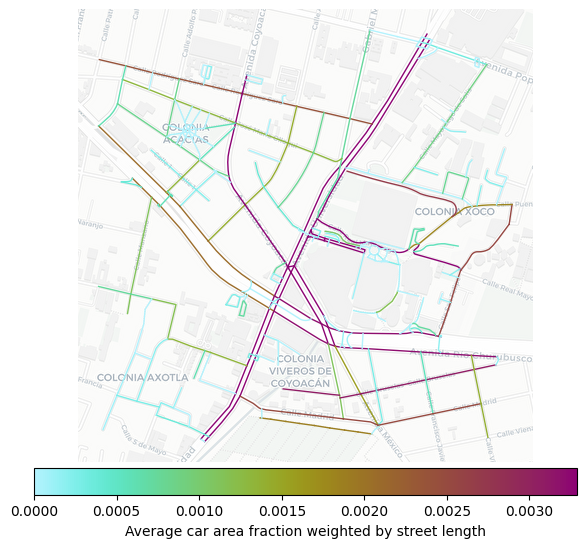

In [10]:


cmap = cm.hawaii_r

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(street_sampler, 
"Length-weighted car area", 
variable_type="continuous",
edge_width = 1,
cmap = cmap)
vis.draw_networks(colorbar_label = "Average car area fraction weighted by street length", colorbar_orientation = "horizontal", min_percentile = 1, max_percentile = 99)
vis.add_basemap(alpha = 0.7)
vis.finalize_map()

### Number of windows

In [11]:
feature_to_examine = "window"
window_count_list = []
confidences_window_counts = []

for i in tqdm(range(0,len(points_data))):
    point_dictionary = points_data[i]
    view_paths = point_dictionary["view_paths"]

    window_counts = 0
    n_paths = len(view_paths)
    mean_confidence = 0
    for j in range(0,len(view_paths)):
        img = cv2.imread(view_paths[j])
        #By default the feature that is obtained is the number of instances in the image. I will show how to extract
        #other attributes like area of elements in the next cell. 

        results = facade_feat_extractor.compute([feature_to_examine], img, confidence_threshold = 0.2)
        count, confidences = results[feature_to_examine]
        window_counts += count
        if(len(confidences) > 0):
            mean_confidence += np.mean(confidences)
    if(n_paths>0):
        mean_confidence = mean_confidence/n_paths

    window_count_list.append(window_counts)
    confidences_window_counts.append(mean_confidence)
street_sampler.tag_streets(
    "Window count", 
    window_count_list,
    method = "sum"
)



100%|██████████| 279/279 [05:39<00:00,  1.22s/it]


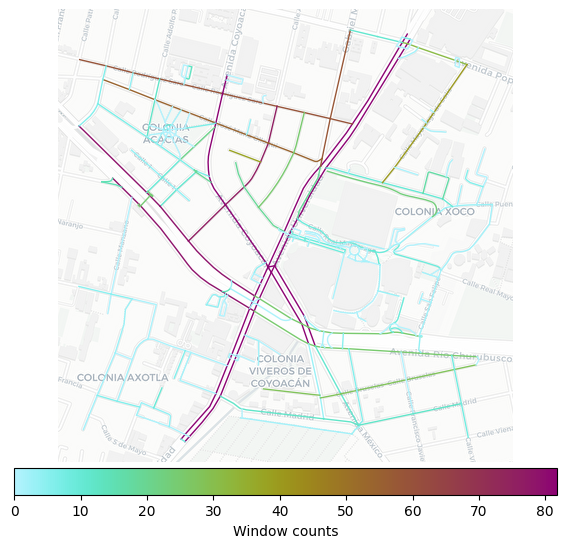

In [12]:
cmap = cm.hawaii_r

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(street_sampler, 
"Window count", 
variable_type="continuous",
edge_width = 1,
cmap = cmap)
vis.draw_networks(colorbar_label = "Window counts", colorbar_orientation = "horizontal", min_percentile = 1, max_percentile = 99)
vis.add_basemap(alpha = 0.7)
vis.finalize_map()


### Window-to-wall ratio

In [13]:


epsilon = 1e-6  # To avoid division by zero

wwr_calculation = lambda facade_calculator, image, classes, threshold: {
    "WWR": (
        # Compute area ratio
        np.logical_or.reduce(
            facade_calculator.get_masks(image, threshold, "window")[0]
        ).sum() / (
            np.logical_or.reduce(
                facade_calculator.get_masks(image, threshold, "facade")[0]
            ).sum() + epsilon
        ),
        # Return both window and facade confidences as a tuple of means
        (
            np.mean(facade_calculator.get_masks(image, threshold, "window")[1] or [0]),
            np.mean(facade_calculator.get_masks(image, threshold, "facade")[1] or [0])
        )
    )
}

feature_to_examine = "WWR"
wwr_list = []
confidences_windows = []
confidences_facades = []

for i in tqdm(range(len(points_data))):
    point_dictionary = points_data[i]
    view_paths = point_dictionary["view_paths"]

    wwr_accum = 0
    n_paths = len(view_paths)
    mean_conf_window = 0
    mean_conf_facade = 0

    for view_path in view_paths:
        img = cv2.imread(view_path)

        results = facade_feat_extractor.compute(
            [feature_to_examine],
            img,
            operation=wwr_calculation,
            confidence_threshold=0.2
        )
        
        wwr_value, (conf_window, conf_facade) = results[feature_to_examine]
        wwr_accum += wwr_value / n_paths
        mean_conf_window += conf_window
        mean_conf_facade += conf_facade

    if n_paths > 0:
        mean_conf_window /= n_paths
        mean_conf_facade /= n_paths
    if(wwr_accum<1):
        wwr_list.append(wwr_accum)
    else:
        wwr_list.append(None)
    confidences_windows.append(mean_conf_window)
    confidences_facades.append(mean_conf_facade)




100%|██████████| 279/279 [22:06<00:00,  4.75s/it]


In [14]:
street_sampler.tag_streets(
    "WWR", 
    wwr_list,
    method = "mean"
)


street_means = []
street_lengths = []

for street in street_sampler.streets:
    value = street.get_attribute_value("WWR")  # Attribute name for WWR
    length = street.get_complete_length()

    if value is not None and length > 0:
        street_means.append(value)
        street_lengths.append(length)
    else:
        street_means.append(None)
        street_lengths.append(0.0)

total_length = sum(length for length in street_lengths if length > 0)

weighted_means = [
    value * (length / total_length) if value is not None and length > 0 else None
    for value, length in zip(street_means, street_lengths)
]

street_sampler.tag_streets_raw("Length-weighted WWR", weighted_means)

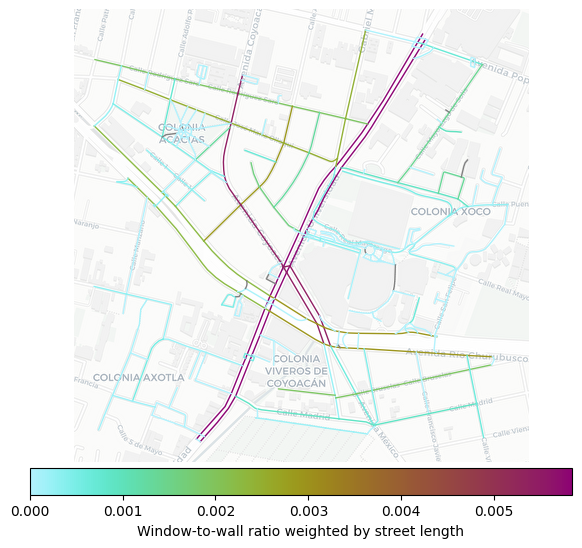

In [15]:
import cmcrameri.cm as cm
from alivestreets.visualization.map_visualizer import MapVisualizer
cmap = cm.hawaii_r

vis = MapVisualizer()
vis.initialize_map(figsize = (7,7))

vis.add_street_sampler(street_sampler, 
"Length-weighted WWR", 
variable_type="continuous",
edge_width = 1,
cmap = cmap)
vis.draw_networks(colorbar_label = "Window-to-wall ratio weighted by street length", colorbar_orientation = "horizontal", min_percentile=0, max_percentile=100)
vis.add_basemap(alpha = 0.7)
vis.finalize_map()

### Window-to-wall ratio over a trajectory

In [16]:
#This is something not so good, if you only tagged per street trajectories won't work, you need to have a list of values one per point, 
#if you used the raw tagging you need to repeat some values to generate that list and then retag, i kind of hate that i have to do this so i will make
#sure to fix this usage for future versions 
weighted_point_values = []

for street in street_sampler.streets:
    weighted_value = street.get_attribute_value("Length-weighted WWR")
    n_points = street.get_number_of_sampling_points()
    weighted_point_values.extend([weighted_value if not weighted_value is None else None] * n_points)

street_sampler.tag_streets("Length-weighted WWR", weighted_point_values, method="mean")

[10, 9, 8, 7, 6, 5, 4, 3, 31, 32, 33, 46, 45, 423, 422, 421, 420, 419, 418, 417, 416, 415, 13, 12, 11, 39, 391, 444, 443, 442, 441, 440, 448, 447, 446, 445, 451, 450]


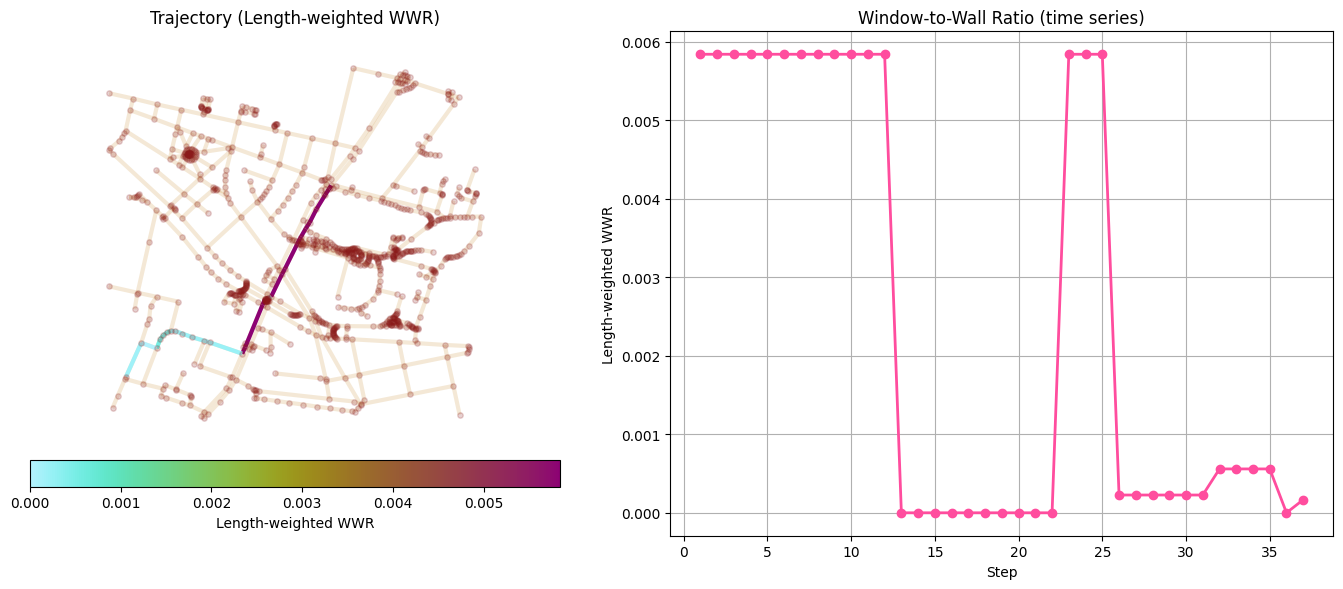

In [17]:
from alivestreets.network.graph_utilities import build_graph_from_sampler, attach_sampler_street_attributes_to_graph, attach_sampler_segment_attributes_to_graph
from alivestreets.visualization.trajectory_visualizer import plot_trajectory_on_graph, plot_attribute_time_series
import networkx as nx
import matplotlib.pyplot as plt

# Build the graph from the street sampler
graph = build_graph_from_sampler(street_sampler)
undirected_graph = graph.to_undirected()

# Attach WWR attribute to the graph edges
attach_sampler_segment_attributes_to_graph(
    undirected_graph, 
    street_sampler, 
    "Length-weighted WWR", 
    aggregation="mean", 
)

# Define start and end nodes for the trajectory
initial_node = 10
final_node = 450

# Use undirected graph for path calculation
#undirected_graph = graph.to_undirected()

# Compute the shortest path based on edge length
trajectory = nx.shortest_path(
    undirected_graph, 
    source=initial_node, 
    target=final_node, 
    weight="length"
)
print(trajectory)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the trajectory on the graph with WWR visualization
plot_trajectory_on_graph(
    G=undirected_graph,
    trajectory=trajectory,
    attribute_name="Length-weighted WWR",
    edge_size=3.0,
    width=3.0, 
    node_size=15,
    ax=ax1, 
    alpha=0.2, 
    node_color="#8B1A1A",
    cmap = cmap,
    min_percentile = 0,
    max_percentile = 100
)

# Plot the WWR time series along the trajectory
plot_attribute_time_series(
    trajectory=trajectory,
    G=undirected_graph,
    attribute_name="Length-weighted WWR",
    ax=ax2, 
    title="Window-to-Wall Ratio (time series)"
)

plt.tight_layout()
plt.show()